# Хакатон "Лента х Практикум"

## Описание проекта

**Краткое описание:**
Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного
производства. Гранулярность ТК-SKU-День.

**Задача:**
Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных
признаков.

**Цель:**
Сгенерировать различные признаки и придумать интерпретируемую, описывающую правильные
зависимости (повышение цены вызывает логичное падение спроса), модель прогноза спроса.
Дальше необходимо сделать подневной прогноз спроса на тестовом периоде для каждого товара
и магазина, и команда Ленты оценит его качество в сравнении с свершившимся фактом.
Метрикой качества будет выступать WAPE, посчитанный на уровне товар, магазин, день. Если
есть пропущенные значения и по каким-то товарам не предоставлен прогноз, прогноз считается
равным нулю.

```python
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))
```

**Требования к результату:**
1. Файл в зафиксированном формате с результатом прогноза спроса(sales_submission.csv).
2. Воспроизводимый код на Python
3. Описание решения:
    + Описание модели прогноза спроса, которую вы зафитили
        + Признаки
        + интерпретация (`shapley values`),
        + кросс-валидация
        + алгоритмы
    + Описание вашего алгоритма оптимизации:
        + методология расчетов
        + скорость оптимизации

**Критерии оценки:**
У вас есть тестовый датасет за более поздние периоды в рамках групп товаров собственного
производства. Ваш алгоритм должен показать высокую точность прогнозирования спроса с
использованием признаков, которые вы сочтёте нужными.
Критерии оценки – WAPE + алгоритм прогноза спроса является понятным, эффективным и
масштабируемым.

## Знакомство с данными

In [2]:
# импорт осн. библиотек
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
# Константы
FIGSIZE = (15, 6)

Исходный набор данных состоит из четырёх датасетов:
1. `pr_df.csv` - данные по товарной иерархии,
2. `pr_st.csv` - данные по магазинам,
3. `sales_df_train.csv` - данные по продажам за скользящий год для обучения,
4. `sales_submission.csv` - пример файла с результатом работы модели прогноза спроса.

In [3]:
#чтение датасетов
pr_df = pd.read_csv('datasets/pr_df.csv')
pr_st = pd.read_csv('datasets/st_df.csv')
sales_df_train = pd.read_csv('datasets/sales_df_train.csv', parse_dates=['date'])
sales_submission = pd.read_csv('datasets/sales_submission.csv', parse_dates=['date'])

### Товарная иерархия

Это сводная таблица, несущая исключительно информационный характер. Описание колонок по значению, от большего к меньшему: pr_group_id -> pr_cat_id -> pr_subcat_id -> pr_sku_id.
- `pr_group_id` – захэшированная группа товара;
- `pr_cat_id` – захэшированная категория товара;
- `pr_subcat_id` – захэшированная подкатегория товара;
- `pr_sku_id` – захэшированное id товара;
- `pr_uom_id` - маркер, обозначающий продаётся товар на вес или в ШТ.

In [4]:
# изменение порядка между столбцами
pr_df = pr_df[['pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_sku_id', 'pr_uom_id']]

display(pr_df)
print(pr_df.info())
print('Кол-во явных дубликатов:', pr_df.duplicated().sum())

,pr_group_id,pr_cat_id,pr_subcat_id,pr_sku_id,pr_uom_id
0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,fd064933250b0bfe4f926b867b0a5ec8,17
1,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,71c9661741caf40a92a32d1cc8206c04,17
2,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,00b72c2f01a1512cbb1d3f33319bac93,17
3,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,9bc40cd2fe4f188f402bb41548c5e15c,17
4,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,3a74a370c8eb032acb11ad9119242b8f,17
...,...,...,...,...,...
2045,c74d97b01eae257e44aa9d5bade97baf,a2cc63e065705fe938a4dda49092966f,4589b8f516d28558b3850c37776cadc8,2c3b895d9fccc33226fee2c521618893,1
2046,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,c0a667df8f0d6ee98dda972b0870fabf,6058d6b7d1f04803d15d1896d3256c92,1
2047,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,34d2777e78ccf007523e2dd1fcea6b2d,3beeab85046ca201d73bb9d129bcfc3f,17
2048,aab3238922bcc25a6f606eb525ffdc56,3de2334a314a7a72721f1f74a6cb4cee,0f3abfd67959c079e7b3759440e7415c,b9e2f33d70ffb02d6d04f470da2e45c9,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_group_id   2050 non-null   object
 1   pr_cat_id     2050 non-null   object
 2   pr_subcat_id  2050 non-null   object
 3   pr_sku_id     2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB
None
Кол-во явных дубликатов: 0


In [5]:
# подсчёт кол-ва уникальных значений
print('Кол-во групп:', len(pr_df['pr_group_id'].unique()))
print('Кол-во категорий:', len(pr_df['pr_cat_id'].unique()))
print('Кол-во подкатегорий:', len(pr_df['pr_subcat_id'].unique()))
print('Кол-во уникальных товаров:', len(pr_df['pr_sku_id'].unique()))
print('Значения меток фасовки товаров (на вес / поштучно):', pr_df['pr_uom_id'].unique())

Кол-во групп: 9
Кол-во категорий: 43
Кол-во подкатегорий: 170
Кол-во уникальных товаров: 2050
Значения меток фасовки товаров (на вес / поштучно): [17  1]


Пропуски отсутствуют. Столбец `pr_sku_id` содержит уникальные значения и может выполнять роль индекса (первичного ключа). Тип данных соответствует, за исключения столбца `pr_uom_id`. Возможно, для него подойдёт bool-ый тип данных, поскольку значения бинарны.

### Данные по магазинам

Это сводная таблица, несущая исключительно информационный характер. Описание столбцов:
- `st_id` – захэшированное id магазина;
- `st_city_id` – захэшированное id города;
- `st_division_code id` – захэшированное id дивизиона;
- `st_type_format_id` – id формата магазина;
- `st_type_loc_id` – id тип локации/окружения магазина;
- `st_type_size_id` – id типа размера магазина;
- `st_is_active` – флаг активного магазина на данный момент.

In [6]:
display(pr_st)
print(pr_st.info())
print('Кол-во явных дубликатов:', pr_st.duplicated().sum())

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
5,53e19f3dbb211f20b20b45668303c1b6,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,20,1
6,42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
7,c81e728d9d4c2f636f067f89cc14862c,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
8,fa7cdfad1a5aaf8370ebeda47a1ff1c3,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
9,f7e6c85504ce6e82442c770f7c8606f0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 804.0+ bytes
None
Кол-во явных дубликатов: 0


In [7]:
# уникальные значения
print('Кол-во магазинов:', len(pr_st['st_id'].unique()))
print('Кол-во городов:', len(pr_st['st_city_id'].unique()))
print('Кол-во дивизионов:', len(pr_st['st_division_code'].unique()))
print('Форматы магазинов:', pr_st['st_type_format_id'].unique())
print('Типы локации/окружения:', pr_st['st_type_loc_id'].unique())
print('Типы размеров магазина:', pr_st['st_type_size_id'].unique())

Кол-во магазинов: 12
Кол-во городов: 7
Кол-во дивизионов: 6
Форматы магазинов: [4 1 2]
Типы локации/окружения: [3 1 2]
Типы размеров магазина: [19 12 28  8 20 32]


In [8]:
# не активные магазины
pr_st[pr_st['st_is_active'] == 0]

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
10,62f91ce9b820a491ee78c108636db089,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,32,0


Всего 12 магазинов в 7 городах (6 дивизионах), которые расположены на 3х типах локаций. Среди них встречаются 3 формата магазинов: 1, 2 и 4 (внезапно), а так же 6 типоа размера магазинов. Все эти признаки **категориальные** и подлежат кодированию, возможно.

Два магазина, не действующих на данный момент, вероятно стоит удалить, поскольку прогнозирование для него не целесообразно.

### Данные по продажам

Данные собраны за скользящий год. Предназначены для обучения. В датасете не содержатся данных о списании невостребованных/неликвидных остатков товаров. Описание столбцов:
- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата;
- `pr_sales_type_id` – флаг наличия промо;
- `pr_sales_in_units` – число проданных товаров всего (с промо и без);
- `pr_promo_sales_in_units` – число проданных товаров с признаком промо;
- `pr_sales_in_rub` – продажи товаров всего (с промо и без);
- `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ.

In [9]:
display(sales_df_train)
print(sales_df_train.info())
print('Кол-во явных дубликатов:', sales_df_train.duplicated().sum())
print('Временной период: от {} до {}'.format(sales_df_train['date'].min().date(), sales_df_train['date'].max().date()))

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0
...,...,...,...,...,...,...,...,...
883010,c81e728d9d4c2f636f067f89cc14862c,a0150fefa71d6606d5e642fa0e7b8ad8,2022-12-13,1,1.0,1.0,33.0,33.0
883011,42a0e188f5033bc65bf8d78622277c4e,5b146d93f822459260216df28e572eca,2023-04-18,0,1.0,0.0,192.0,0.0
883012,42a0e188f5033bc65bf8d78622277c4e,c8bd18ea08d2f47cb0a7992f11ada9de,2022-08-16,0,5.0,0.0,970.0,0.0
883013,f7e6c85504ce6e82442c770f7c8606f0,b960c6ee5b5efa12e73f810204b561a8,2023-04-23,0,4.0,0.0,262.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 53.9+ MB
None


Кол-во явных дубликатов: 0
Временной период: от 2022-08-01 до 2023-07-18


Таблица содержит более 880 тыс. записей о продажах. Каждая запись фиксирует "Где? Что? Когда?" было продано, а также кол-во, стоимость и условия этих продаж (промо-акция / нет). Фактически данные собраны за неполный год (подробности выше).

**Планы:**
- Стоит проконтролировать тип данных в столбцах: `pr_sales_in_units`, `pr_promo_sales_in_units`,	`pr_sales_in_rub`,	`pr_promo_sales_in_rub`
- Стоит проконтролировать целостность временной линии.
- Стоит ли устранить недочет с равенством `pr_sales_in_units` и `pr_promo_sales_in_units`, когда `pr_sales_type_id` равно 1?
- Возможно стоит изменить тип данных столбцов с датами на `datetime64`

### Пример файла с результатом работы модели прогноза спроса

Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями). Столбцы:
- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата (день);
- `target` – спрос в ШТ.

In [10]:
display(sales_submission)
print(sales_submission.info())
print('Кол-во явных дубликатов:', sales_submission.duplicated().sum())

,st_id,pr_sku_id,date,target
0,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,0
1,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2023-07-20,0
2,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2023-07-20,0
3,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-20,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,2023-07-20,0
...,...,...,...,...
43689,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fd519eb13005448a303df1089505a42b,2023-08-01,0
43690,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fdb89dfd1a27256904eb5a5734252102,2023-08-01,0
43691,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-08-01,0
43692,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe5d18ae6650335830e4c1dbd9e6ddb9,2023-08-01,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43694 entries, 0 to 43693
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   st_id      43694 non-null  object        
 1   pr_sku_id  43694 non-null  object        
 2   date       43694 non-null  datetime64[ns]
 3   target     43694 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.3+ MB
None
Кол-во явных дубликатов: 0


**Промежуточный вывод:**
- наименование столбцов выполнено в едином стандарте,
- тип данных
- пропуски отсутствуют во всех датасетах,
- аномалии/выбросы
- явные дубликаты - отсутствуют

___

## Разведочный анализ данных

- (День — Товар — Магазин — Продажа в штуках — Продажа в рублях — доля продаж по ПРОМО)
- Построить графики временных рядов
- Исследовать пропуски, выбросы и корреляции между товарами, заполнить пропуски, нивелировать выбросы
- Провести предобработку данных

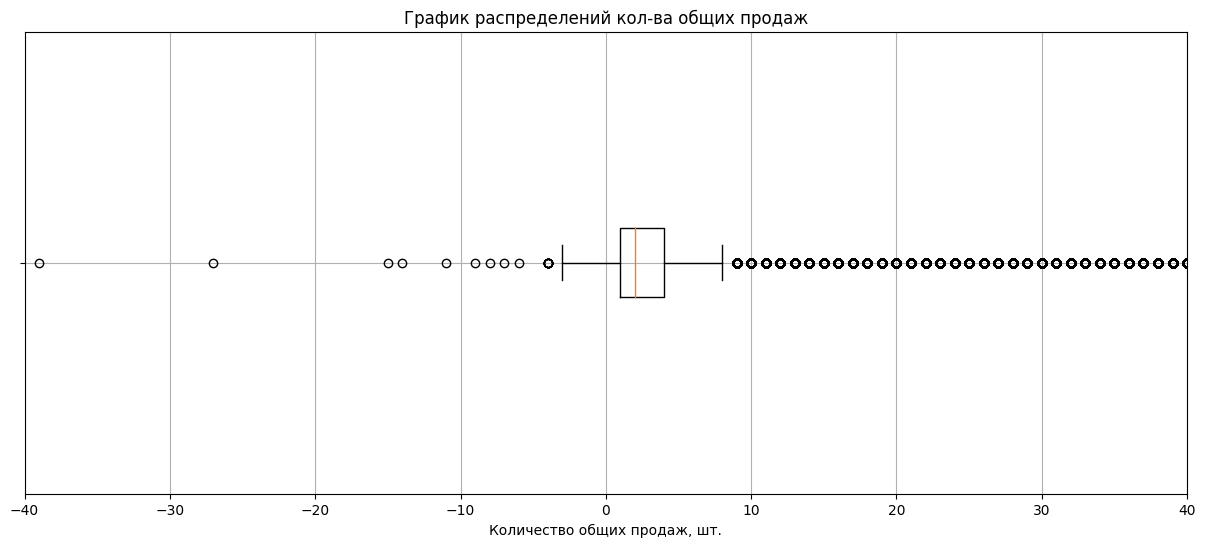

,pr_sales_in_units
count,883015.000000
mean,5.037956
std,13.402984
min,-39.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,2348.000000


In [84]:
# данные о продажах
plt.figure(figsize=FIGSIZE)
plt.boxplot(sales_df_train['pr_sales_in_units'], vert=False, labels=[''])
plt.title('График распределений кол-ва общих продаж')
plt.xlabel('Количество общих продаж, шт.')
plt.xlim(-40, 40)
plt.grid(True)
plt.show()

sales_df_train['pr_sales_in_units'].describe().to_frame()

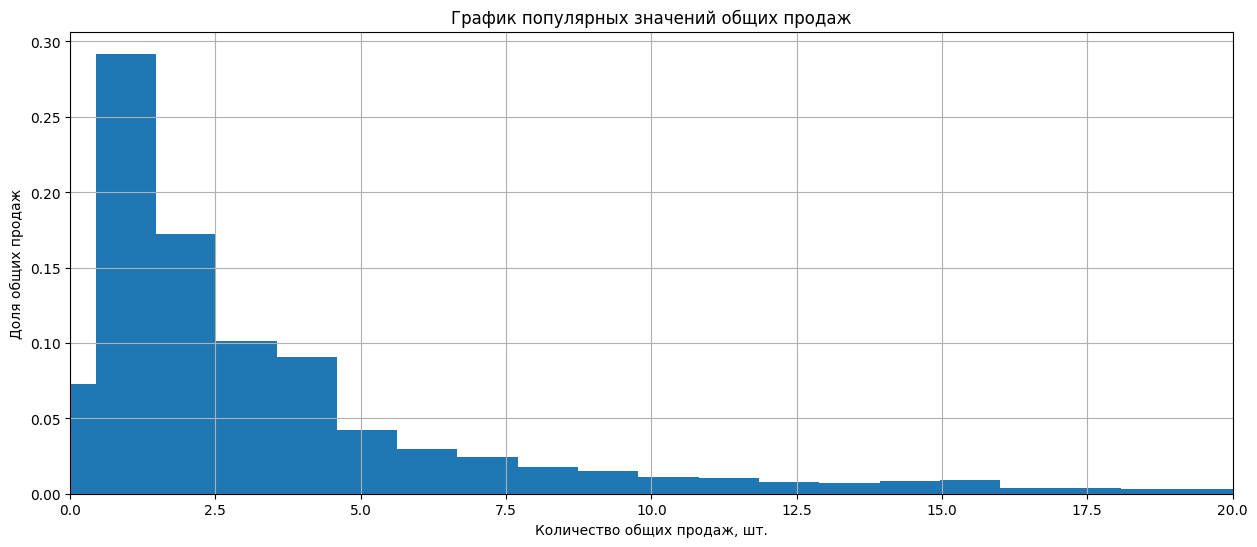

In [ ]:
# распределение положительных значений общих продаж
plt.figure(figsize=FIGSIZE)
plt.hist(sales_df_train['pr_sales_in_units'], density=True, bins=2300)
plt.title('График популярных значений общих продаж')
plt.ylabel('Доля общих продаж')
plt.xlabel('Количество общих продаж, шт.')
plt.xlim(0, 20)
plt.grid(True)
plt.show()

In [32]:
# кол-во отрицательных общих продаж
negative_sales_in_units = sales_df_train[sales_df_train['pr_sales_in_units'] < 0].value_counts('pr_sales_in_units',
                                                                                               sort=False).to_frame()
negative_sales_in_units.loc['Total:', 'count'] = negative_sales_in_units['count'].sum()
negative_sales_in_units['count'] = negative_sales_in_units['count'].astype('int')
display(negative_sales_in_units)
del negative_sales_in_units

,count
pr_sales_in_units,
-39.0,1
-27.0,1
-15.0,1
-14.0,1
-11.0,1
-9.0,1
-8.0,1
-7.0,1
-6.0,1


Столбец `pr_sales_in_units`, отображающий общее кол-во продаж товара содержит крайне большие значения, а так же отрицательны значения. 

Крайне большие значение встречаются очень редко. Их присутствие сильно сказывается на распределении продаж. По этой причине от них необходимо избавиться. Границей между нормальными значениями и выбросами будет сумма 3-его квантиля и стандартного отклонения (Q3 + std).

Отрицательных значений не много 71 объект. Судя по частоте их встречи, предполагаю, что вероятней это возвраты. Чаще всего возвращали одну единицу товара, и значительно реже возвращали 6 и более товаров единовременно.

In [88]:
min_sales = 0
max_sales = sales_df_train['pr_sales_in_units'].quantile(0.75) + sales_df_train['pr_sales_in_units'].std()
display(sales_df_train[(sales_df_train['pr_sales_in_units'] > min_sales) & (sales_df_train['pr_sales_in_units'] < max_sales)])

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0
5,42a0e188f5033bc65bf8d78622277c4e,3474f0e025c7deb7e127a35763bc5512,2022-11-03,0,3.0,0.0,123.0,0.0
...,...,...,...,...,...,...,...,...
883010,c81e728d9d4c2f636f067f89cc14862c,a0150fefa71d6606d5e642fa0e7b8ad8,2022-12-13,1,1.0,1.0,33.0,33.0
883011,42a0e188f5033bc65bf8d78622277c4e,5b146d93f822459260216df28e572eca,2023-04-18,0,1.0,0.0,192.0,0.0
883012,42a0e188f5033bc65bf8d78622277c4e,c8bd18ea08d2f47cb0a7992f11ada9de,2022-08-16,0,5.0,0.0,970.0,0.0
883013,f7e6c85504ce6e82442c770f7c8606f0,b960c6ee5b5efa12e73f810204b561a8,2023-04-23,0,4.0,0.0,262.0,0.0


## Исследовать признаки (EDA)

Посчитать цены
    - Стоимость одного товара (за день)
    - Стоимость группы товаров (за день)